In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from numba import njit

In [3]:
normal_dist = lambda x, m, s: 1 / (np.sqrt(2*np.pi) * s) * np.exp(-1/2 * ((x - m) / s)**2)

@njit
def b_maxL_2(m, t, C):
    first = C[0]+C[1]-(m[0]+m[1])*(t[0]+t[1])
    root = (C[0]+C[1]+(m[0]-m[1])*(t[0]+t[1]))**2-4*C[0]*(m[0]-m[1])*(t[0]+t[1])
    res = (first+np.sqrt(root))/(2*(t[0]+t[1]))
    if res < 0:
        return 0
    return res

In [145]:
# true incoming rates
s1 = 200.
s2 = 100.
b = 300.

# include time, even though rates = counts here, only included so that b_max_L doesn't have to be rewritten
t1 = 1.
t2 = 1.

true_counts = np.array([s1, s2, b, b])
cluster_size = 2

# How many posterior samples
num_posterior_samples = 300
# How many predictive samples, equivalent to number of real data bins in real analysis
num_predictive_samples = 1000
# Bins in plot
num_bins = 100

# standard deviation of posterior
posterior_std = np.array([0., 0.])
# samples of posterior
posterior_samples = np.random.normal(true_counts[:cluster_size], posterior_std, size=(num_posterior_samples, cluster_size))

# Each posterior sample is sampled into the predictive samples
posterior_predictive_source_counts = np.random.poisson(posterior_samples, (num_predictive_samples, num_posterior_samples, cluster_size))
# posterior_predictive_source_counts = posterior_predictive_source_counts.swapaxes(0, 1)
# posterior_predictive_source_counts = posterior_predictive_source_counts.swapaxes(1, 2)

# actual measured counts, available to use in analysis
measured_counts = np.random.poisson(true_counts, (num_predictive_samples, len(true_counts)))
measured_counts_combined = measured_counts[:,:cluster_size] + measured_counts[:,cluster_size:]

# maximum likelihood background
b_max_L = np.zeros((num_predictive_samples, num_posterior_samples))
for i in range(num_posterior_samples):
    for j in range(num_predictive_samples):
        b_max_L[j, i] = b_maxL_2(posterior_samples[i], [t1, t2], measured_counts_combined[j])
# n, bins, _ = plt.hist(b_max_L.flatten(), bins=num_bins)
# x = bins
# y = normal_dist(bins, b, np.sqrt(b))
# y = y * np.amax(n) / np.amax(y)
# plt.plot(x, y)


In [146]:
# Repeat for easier usage
posterior_predictive_background_counts = np.repeat(b_max_L[:,:,np.newaxis], 2, axis=2)
# Sample posterior predictive counts
posterior_predictive_counts = np.random.poisson(posterior_predictive_background_counts + posterior_predictive_source_counts)

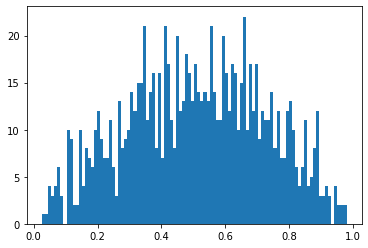

In [147]:
# Sort posterior predictive counts for each predictive sample, i.e. sort posterior samples
argsort = np.argsort(posterior_predictive_counts, axis=1)
total = np.take_along_axis(posterior_predictive_counts, argsort, axis=1)

# Find placement of measured counts in sorted array
cdf = np.zeros(num_predictive_samples)
for i in range(num_predictive_samples):
    cdf[i] = ((np.searchsorted(total[i,:,0], measured_counts_combined[i, 0], "left")
                     + np.searchsorted(total[i,:,0], measured_counts_combined[i, 0], "right"))
                     / (2 * num_posterior_samples))
    
_ = plt.hist(cdf, bins=num_bins)


In [88]:
@njit
def calc_bmaxL_variance_matrix(b_array, s1_array, t1_array, s2_array, t2_array, num_samples=1000000):
    variance_matrix = np.zeros((len(b_array), len(s1_array), len(t1_array), len(s2_array), len(t2_array), 2, 2, 2))
    for b_i, b in enumerate(b_array):
        for s1_i, s1 in enumerate(s1_array):
            for t1_i, t1 in enumerate(t1_array):
                for s2_i, s2 in enumerate(s2_array):
                    for t2_i, t2 in enumerate(t2_array):
                        bd1 = np.zeros(num_samples)
                        bd2 = np.zeros(num_samples)
                        sd1 = np.zeros(num_samples)
                        sd2 = np.zeros(num_samples)
                        for n_i in range(num_samples):
                            s1m = np.random.poisson(t1 * s1)
                            s2m = np.random.poisson(t2 * s2)
                            b1m = np.random.poisson(t1 * b)
                            b2m = np.random.poisson(t2 * b)
                            
                            c1m = s1m + b1m
                            c2m = s2m + b2m
                            b_max_L = b_maxL_2(np.array([s1, s2]), np.array([t1, t2]), np.array([c1m, c2m]))
                            
                            bd1[n_i] = b1m - b_max_L*t1
                            bd2[n_i] = b2m - b_max_L*t2
                            sd1[n_i] = s1m - s1*t1
                            sd2[n_i] = s2m - s2*t2
                            
                        # if b_i == 0 and s1_i == 0 and s2_i == 0:
                        #     print(b, s1, t1, s2, t2)
                        #     print(s1m, s2m, b1m, b2m)
                        #     print([s1, s2], [t1, t2], [c1m, c2m])
                        #     print(b_maxL_2([s1, s2], [t1, t2], [c1m, c2m]))
                        #     print(b1m - b_max_L*t1, b2m - b_max_L*t2)
                        #     print(s1m - s1*t1, s2m - s2*t2)
                        #     print(np.cov(bd1, sd1))
                        variance_matrix[b_i, s1_i, t1_i, s2_i, t2_i, 0, :, :] = np.cov(bd1, sd1)
                        variance_matrix[b_i, s1_i, t1_i, s2_i, t2_i, 1, :, :] = np.cov(bd2, sd2)
                        
    return variance_matrix

In [133]:
input_b = np.geomspace(1,1000,3)
input_s1 = np.geomspace(1,1000,3)
input_t1 = np.geomspace(600, 6000, 3)
input_s2 = np.geomspace(1,1000,3)
input_t2 = np.geomspace(600, 6000, 3)

In [134]:
v = calc_bmaxL_variance_matrix(input_b, input_s1, input_t1, input_s2, input_t2)

1.0 1.0 600.0 1.0 600.0
580 606 563 578
[1.0, 1.0] [600.0, 600.0] [1143, 1184]
0.9391666666666667
-0.5 14.5
-20.0 6.0
[[ 599.89368581 -298.66488048]
 [-298.66488048  598.35510965]]
1.0 1.0 600.0 1.0 1897.3665961010286
619 1945 557 1865
[1.0, 1.0] [600.0, 1897.3665961010286] [1176, 3810]
0.9965030395554697
-40.901823733281844 -25.731580165690275
19.0 47.63340389897144
[[ 598.96721165 -143.1840293 ]
 [-143.1840293   599.38930212]]
1.0 1.0 600.0 1.0 6000.0
606 5977 629 6036
[1.0, 1.0] [600.0, 6000.0] [1235, 12013]
1.0072727272727273
24.636363636363626 -7.636363636363967
6.0 -23.0
[[600.20286142 -55.12459961]
 [-55.12459961 600.39180278]]
1.0 1.0 1897.3665961010286 1.0 600.0
1902 616 1826 646
[1.0, 1.0] [1897.3665961010286, 600.0] [3728, 1262]
0.9981047267111499
-67.77056787228184 47.13716397331007
4.633403898971437 16.0
[[ 1895.3303746  -1438.49598396]
 [-1438.49598396  1894.61099854]]
1.0 1.0 1897.3665961010286 1.0 1897.3665961010286
1896 1889 1919 1848
[1.0, 1.0] [1897.3665961010286, 18

In [135]:
v[1, 1, 0, 0, 0]

array([[[18953.05584709, -6438.40982249],
        [-6438.40982249, 18963.33310494]],

       [[ 6853.62880832,  -395.87598682],
        [ -395.87598682,   600.14099214]]])

In [136]:
input_b[1]*input_t1

array([ 18973.66596101,  60000.        , 189736.6596101 ])

In [137]:
@njit
def calc_multivariate_normal(num_predictive_samples, num_posterior_samples, b_max_L, posterior_samples, v):
    posterior_predictive_counts = np.zeros((num_predictive_samples, num_posterior_samples))
    for i in range(num_predictive_samples):
        for j in range(num_posterior_samples):
            counts = np.random.multivariate_normal([b_max_L[i, j], posterior_samples[j, 0]], v[0,0,0,0,0,0,:,:])
            posterior_predictive_counts[i, j] = np.sum(counts)
    return posterior_predictive_counts

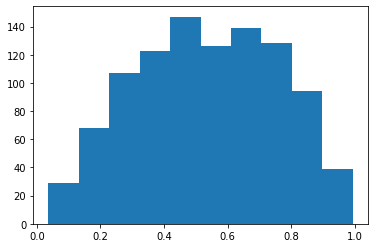

In [152]:
# true incoming rates
s1 = input_s1[0]
s2 = input_s2[1]
b = input_b[1]

# include time, even though rates = counts here, only included so that b_max_L doesn't have to be rewritten
t1 = input_t1[1]
t2 = input_t1[2]

times = np.array([t1, t2])

true_rates = np.array([s1, s2, b, b])
cluster_size = 2

# How many posterior samples
num_posterior_samples = 300
# How many predictive samples, equivalent to number of real data bins in real analysis
num_predictive_samples = 1000
# Bins in plot
num_bins = 10

# standard deviation of posterior
posterior_std = np.array([0.2, 0.0])
# samples of posterior
posterior_samples = np.random.normal(true_rates[:cluster_size], posterior_std, size=(num_posterior_samples, cluster_size))

# Each posterior sample is sampled into the predictive samples
posterior_predictive_source_counts = np.random.poisson(posterior_samples * times, (num_predictive_samples, num_posterior_samples, cluster_size))

# actual measured counts, available to use in analysis
measured_counts = np.random.poisson(true_rates * np.tile(times, 2), (num_predictive_samples, len(true_rates)))
measured_counts_combined = measured_counts[:,:cluster_size] + measured_counts[:,cluster_size:]

# maximum likelihood background
b_max_L = np.zeros((num_predictive_samples, num_posterior_samples))
for i in range(num_posterior_samples):
    for j in range(num_predictive_samples):
        b_max_L[j, i] = b_maxL_2(posterior_samples[i], times, measured_counts_combined[j])
# n, bins, _ = plt.hist(b_max_L.flatten(), bins=num_bins)
# x = bins
# y = normal_dist(bins, b, v[2,2,0,2,0])
# y = y * np.amax(n) / np.amax(y)
# plt.plot(x, y)

# print(np.var(b_max_L - b))
# print(v[2, 2, 0, 2, 0])



posterior_predictive_counts = np.zeros((num_predictive_samples, num_posterior_samples))
for i in range(num_predictive_samples):
    for j in range(num_posterior_samples):
        counts = np.random.multivariate_normal([b_max_L[i, j]*t1, posterior_samples[j, 0]*t1], v[1,0,1,1,2,0,:,:])
        # print([b_max_L[i, j], posterior_samples[j, 0]])
        # print(v[0,0,0,0,0,0,:,:])
        # print(counts)
        # print()
        posterior_predictive_counts[i, j] = np.sum(counts)
        


# # Repeat for easier usage
# posterior_predictive_background_counts = np.repeat(b_max_L[:,:,np.newaxis], 2, axis=2)
# # Sample posterior predictive counts
# posterior_predictive_counts = np.random.poisson(posterior_predictive_background_counts + posterior_predictive_source_counts)
# Sort posterior predictive counts for each predictive sample, i.e. sort posterior samples
argsort = np.argsort(posterior_predictive_counts, axis=1)
total = np.take_along_axis(posterior_predictive_counts, argsort, axis=1)

# Find placement of measured counts in sorted array
cdf = np.zeros(num_predictive_samples)
for i in range(num_predictive_samples):
    cdf[i] = ((np.searchsorted(total[i,:], measured_counts_combined[i, 0], "left")
                     + np.searchsorted(total[i,:], measured_counts_combined[i, 0], "right"))
                     / (2 * num_posterior_samples))
    
_ = plt.hist(cdf, bins=num_bins)


